In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# ------------------------------
# 1. Load Data and Apply Filters
# ------------------------------
def load_irac_footprint_galaxies(LRD_MarIRAC):
    """Load galaxies within the IRAC footprint."""
    with fits.open(LRD_MarIRAC) as hdulist:
        # Check HDU structure (optional)
        hdulist.info()
        
        # Assuming the data is in the first binary table (common for catalogs)
        data = hdulist[1].data  # Update HDU index if needed
        
        # Extract required columns
        ra = data['RA']                # Right Ascension
        dec = data['DEC']              # Declination
        irac_footprint = data['IRAC-footprint']  # Boolean flag
        
        # Filter galaxies in IRAC footprint
        mask = irac_footprint  # Equivalent to irac_footprint == True
        ra_irac = ra[mask]
        dec_irac = dec[mask]
        
        # Optional: Print statistics
        print(f"Total galaxies: {len(ra)}")
        print(f"Galaxies in IRAC footprint: {len(ra_irac)}")
        
    return ra_irac, dec_irac


In [2]:
# ------------------------------
# 2. Plot Sky Positions
# ------------------------------
def plot_sky_positions(ra, dec, title="Galaxies in IRAC Footprint"):
    """Plot RA vs DEC for the subset."""
    plt.figure(figsize=(12, 8))
    plt.scatter(ra, dec, s=2, alpha=0.7, c='darkred')
    plt.xlabel('Right Ascension (RA) [deg]', fontsize=12)
    plt.ylabel('Declination (DEC) [deg]', fontsize=12)
    plt.title(title, fontsize=14)
    plt.gca().invert_xaxis()  # RA increases leftward (astronomical convention)
    plt.grid(ls='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('irac_footprint_skyplot.png', dpi=300, bbox_inches='tight')
    plt.show()

Filename: /home/k3vinpaul/LRDs/LRD_MarIRAC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (11370,)   uint8   
  1  Joined        1 BinTableHDU     43   3341R x 13C   [K, D, D, D, D, D, D, D, D, D, D, L, L]   
Total galaxies: 3341
Galaxies in IRAC footprint: 1509


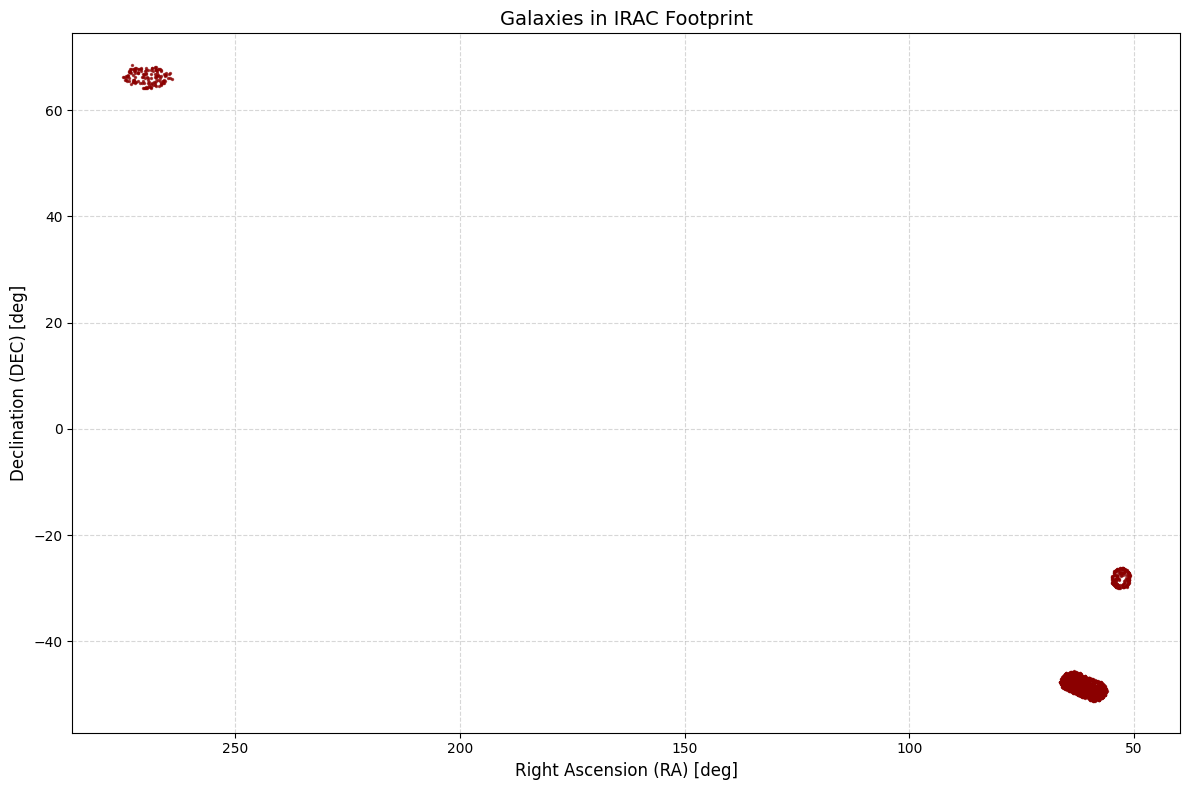

In [4]:
# ------------------------------
# 3. Main Workflow
# ------------------------------
if __name__ == "__main__":
    # Input file (replace with your new FITS file path)
    LRD_MarIRAC = "/home/k3vinpaul/LRDs/LRD_MarIRAC.fits"
    
    # Load data and filter
    ra_irac, dec_irac = load_irac_footprint_galaxies(LRD_MarIRAC)
    
    # Plot
    plot_sky_positions(ra_irac, dec_irac, title="Galaxies in IRAC Footprint")

Original count: 3341
Subset count: 171
Saved to: midt_subset.fits


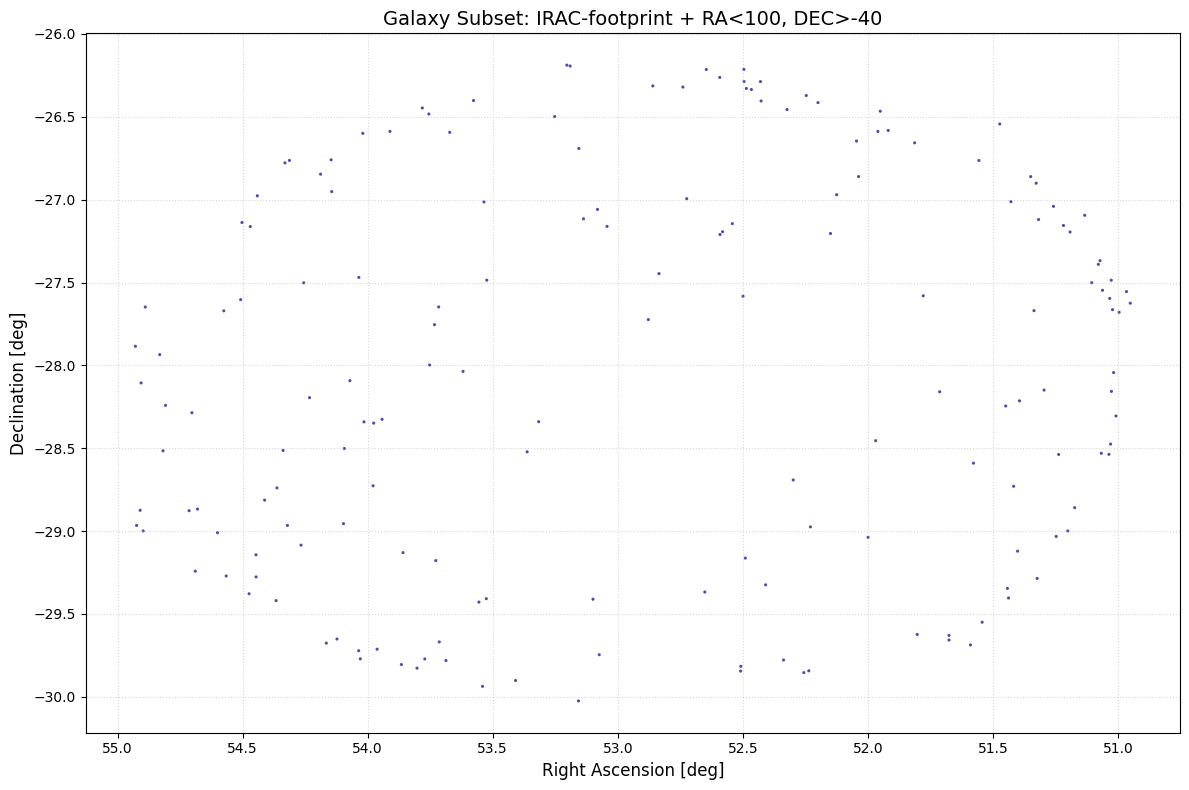

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# ------------------------------
# 1. Load Data and Filter Subset
# ------------------------------
def filter_and_save_subset(input_file, output_file):
    """Filter galaxies and save subset."""
    with fits.open(input_file) as hdulist:
        data = hdulist[1].data  # Assuming data is in first extension
        header = hdulist[1].header
        
        # Create combined mask
        mask = (data['IRAC-footprint'] & 
                (data['RA'] <100) & 
                (data['DEC'] > -40))
        
        subset = data[mask]
        
        # Add filter description to header
        header['HISTORY'] = "Filtered: IRAC-footprint=True, RA<100, DEC>-40"
        
        # Save subset
        fits.BinTableHDU(subset, header=header).writeto(output_file, overwrite=True)
        
        print(f"Original count: {len(data)}")
        print(f"Subset count: {len(subset)}")
        print(f"Saved to: {output_file}")
    
    return subset

# ------------------------------
# 2. Plot Sky Positions
# ------------------------------
def plot_subset(subset):
    """Plot RA vs DEC of filtered galaxies."""
    plt.figure(figsize=(12, 8))
    plt.scatter(subset['RA'], subset['DEC'], 
                s=5, alpha=0.7, c='darkblue', edgecolor='none')
    
    plt.gca().invert_xaxis()  # Astronomical RA convention
    plt.xlabel('Right Ascension [deg]', fontsize=12)
    plt.ylabel('Declination [deg]', fontsize=12)
    plt.title('Galaxy Subset: IRAC-footprint + RA<100, DEC>-40', fontsize=14)
    plt.grid(ls=':', alpha=0.5)
    plt.tight_layout()
    plt.savefig('subset_skyplot.png', dpi=300, bbox_inches='tight')
    plt.show()

# ------------------------------
# 3. Main Execution
# ------------------------------
if __name__ == "__main__":
    input_path = "/home/k3vinpaul/LRDs/LRD_MarIRAC.fits"
    output_path = "midt_subset.fits"
    
    # Filter and save
    subset = filter_and_save_subset(input_path, output_path)
    
    # Plot results if subset is not empty
    if len(subset) > 0:
        plot_subset(subset)
    else:
        print("No galaxies match the criteria - nothing to plot")

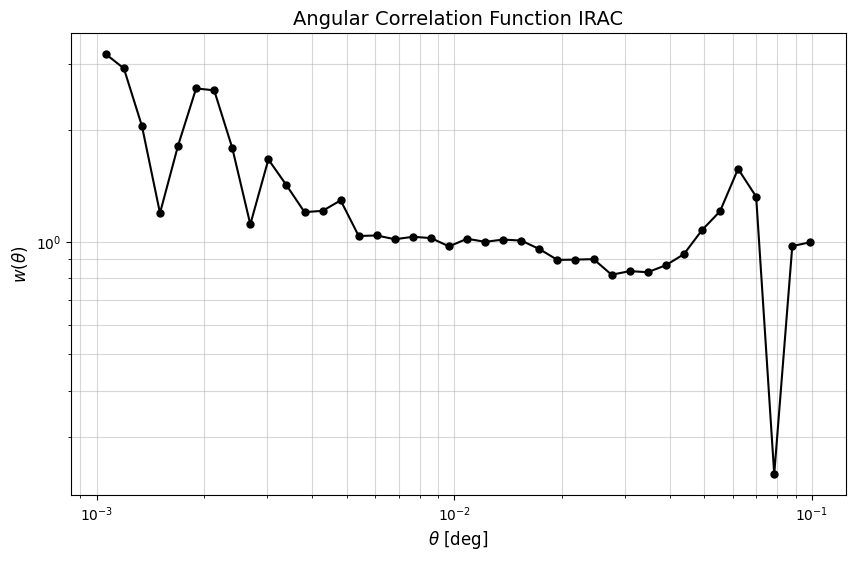

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks

# ------------------------
# 1. Load Data
# ------------------------
def load_subset_data(filename):
    with fits.open(filename) as hdulist:
        data = hdulist[1].data
        ra = data['RA']
        dec = data['DEC']
    return ra, dec

ra_data, dec_data = load_subset_data('mid_subset.fits')

# ------------------------
# 2. Generate Random Catalog
# ------------------------
n_rand = 50 * len(ra_data)  # Ensure sufficient randoms
ra_min, ra_max = np.min(ra_data), np.max(ra_data)
dec_min, dec_max = np.min(dec_data), np.max(dec_data)
ra_rand = np.random.uniform(ra_min, ra_max, n_rand)
dec_rand = np.random.uniform(dec_min, dec_max, n_rand)

# Convert to radians
ra_data_rad = np.radians(ra_data)
dec_data_rad = np.radians(dec_data)
ra_rand_rad = np.radians(ra_rand)
dec_rand_rad = np.radians(dec_rand)

# ------------------------
# 3. Compute Pair Counts
# ------------------------
# Define angular bins (adjust to your science case)
theta_bins = np.logspace(-3., 2, 100) # 100 bins from 0.001 to 100 degrees

# Calculate raw pair counts
DD = DDtheta_mocks(autocorr=1, nthreads=4, binfile=theta_bins,
                   RA1=ra_data_rad, DEC1=dec_data_rad,
                   RA2=ra_data_rad, DEC2=dec_data_rad)
DR = DDtheta_mocks(autocorr=0, nthreads=4, binfile=theta_bins,
                   RA1=ra_data_rad, DEC1=dec_data_rad,
                   RA2=ra_rand_rad, DEC2=dec_rand_rad)
RR = DDtheta_mocks(autocorr=1, nthreads=4, binfile=theta_bins,
                   RA1=ra_rand_rad, DEC1=dec_rand_rad,
                   RA2=ra_rand_rad, DEC2=dec_rand_rad)

# Extract counts
dd, dr, rr = DD['npairs'], DR['npairs'], RR['npairs']

# ------------------------
# 4. Normalize Pair Counts
# ------------------------
n_data = len(ra_data)
n_rand = len(ra_rand)

# Normalization factors
dd_norm_factor = n_data * (n_data - 1) / 2
dr_norm_factor = n_data * n_rand
rr_norm_factor = n_rand * (n_rand - 1) / 2

# Normalized pair counts
dd_normalized = dd / dd_norm_factor
dr_normalized = dr / dr_norm_factor
rr_normalized = rr / rr_norm_factor

# Compute w(theta)
with np.errstate(divide='ignore', invalid='ignore'):
    w_theta = (dd_normalized - 2 * dr_normalized + rr_normalized) / rr_normalized

# Mask invalid bins (RR=0 or NaN)
valid_mask = (rr > 0) & np.isfinite(w_theta)
theta_centers = (theta_bins[1:] + theta_bins[:-1]) / 2
theta_valid = theta_centers[valid_mask]
w_valid = w_theta[valid_mask]

# ------------------------
# 5. Plot
# ------------------------
plt.figure(figsize=(10, 6))
plt.plot(theta_valid, w_valid, 'ko-', markersize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [deg]', fontsize=12)
plt.ylabel(r'$w(\theta)$', fontsize=12)
plt.title('Angular Correlation Function IRAC', fontsize=14)
plt.grid(which='both', alpha=0.5)
plt.savefig('angular_correlation_function_IRAC.png', dpi=300)
plt.show()


Best-fit amplitude (A): 0.303 ± 0.069
Best-fit slope (δ): 0.296 ± 0.040


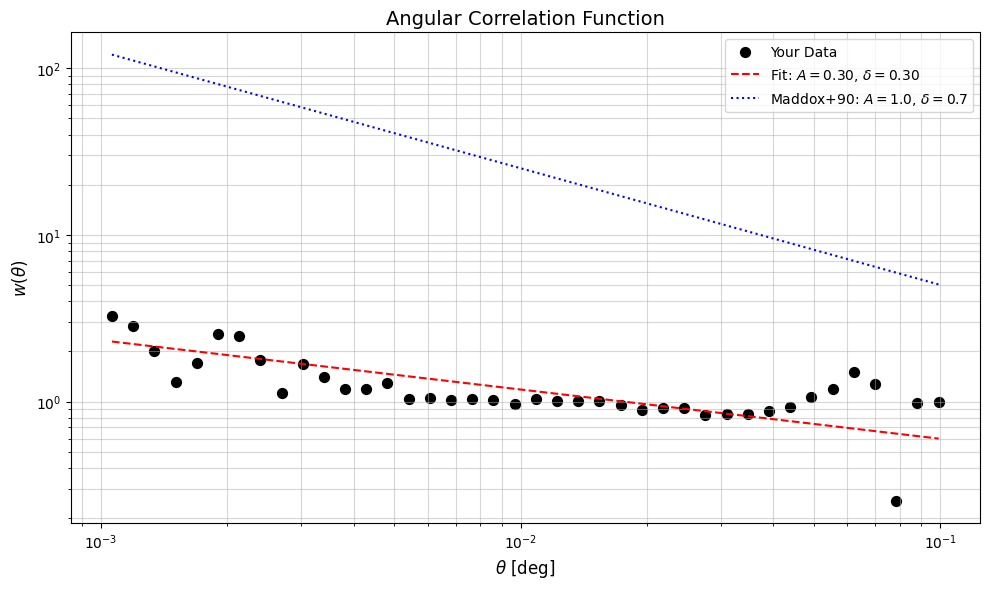

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from scipy.optimize import curve_fit

# =========================================================
# 1. Load Data from FITS File
# =========================================================
def load_subset_data(filename):
    """Load RA, DEC from a FITS file."""
    with fits.open(filename) as hdulist:
        data = hdulist[1].data  # Update HDU index if needed
        ra = data['RA']         # Replace with your RA column name
        dec = data['DEC']       # Replace with your DEC column name
    return ra, dec

# Load your galaxy subset
ra_data, dec_data = load_subset_data('mid_subset.fits')  # Update filename

# =========================================================
# 2. Generate Random Catalog
# =========================================================
n_data = len(ra_data)
n_rand = 50 * n_data  # Random points (adjust if needed)

# Define RA/DEC bounds from data
ra_min, ra_max = np.min(ra_data), np.max(ra_data)
dec_min, dec_max = np.min(dec_data), np.max(dec_data)

# Generate random points within the same region
ra_rand = np.random.uniform(ra_min, ra_max, n_rand)
dec_rand = np.random.uniform(dec_min, dec_max, n_rand)

# Convert to radians (required by Corrfunc)
ra_data_rad = np.radians(ra_data)
dec_data_rad = np.radians(dec_data)
ra_rand_rad = np.radians(ra_rand)
dec_rand_rad = np.radians(dec_rand)

# =========================================================
# 3. Define Angular Bins and Compute Pair Counts
# =========================================================
theta_bins = np.logspace(-3., 2, 100)  # from 0.1 to 100 degrees


# Calculate DD, DR, RR using Corrfunc
DD = DDtheta_mocks(
    autocorr=1, nthreads=4, binfile=theta_bins,
    RA1=ra_data_rad, DEC1=dec_data_rad,
    RA2=ra_data_rad, DEC2=dec_data_rad
)
DR = DDtheta_mocks(
    autocorr=0, nthreads=4, binfile=theta_bins,
    RA1=ra_data_rad, DEC1=dec_data_rad,
    RA2=ra_rand_rad, DEC2=dec_rand_rad
)
RR = DDtheta_mocks(
    autocorr=1, nthreads=4, binfile=theta_bins,
    RA1=ra_rand_rad, DEC1=dec_rand_rad,
    RA2=ra_rand_rad, DEC2=dec_rand_rad
)

# Extract raw pair counts
dd, dr, rr = DD['npairs'], DR['npairs'], RR['npairs']

# =========================================================
# 4. Normalize Pair Counts and Compute w(θ)
# =========================================================
# Normalization factors
dd_norm = n_data * (n_data - 1) / 2  # DD normalization
dr_norm = n_data * n_rand            # DR normalization
rr_norm = n_rand * (n_rand - 1) / 2  # RR normalization

# Normalize pair counts
dd_normalized = dd / dd_norm
dr_normalized = dr / dr_norm
rr_normalized = rr / rr_norm

# Compute ACF (Landy-Szalay estimator)
with np.errstate(divide='ignore', invalid='ignore'):
    w_theta = (dd_normalized - 2 * dr_normalized + rr_normalized) / rr_normalized

# Mask invalid bins (RR=0 or NaN)
valid_mask = (rr > 0) & np.isfinite(w_theta)
theta_centers = (theta_bins[1:] + theta_bins[:-1]) / 2
theta_valid = theta_centers[valid_mask]
w_valid = w_theta[valid_mask]

# =========================================================
# 5. Fit Power Law: w(θ) = A θ^(-δ)
# =========================================================
def power_law(theta, A, delta):
    """Power-law model for the angular correlation function."""
    return A * theta**(-delta)

# Fit the model to valid data
popt, pcov = curve_fit(power_law, theta_valid, w_valid, p0=[1.0, 0.7])
A_fit, delta_fit = popt
A_err, delta_err = np.sqrt(np.diag(pcov))

print(f"Best-fit amplitude (A): {A_fit:.3f} ± {A_err:.3f}")
print(f"Best-fit slope (δ): {delta_fit:.3f} ± {delta_err:.3f}")

# =========================================================
# 6. Plot Results with Literature Comparison
# =========================================================
plt.figure(figsize=(10, 6))

# Plot your data
plt.scatter(theta_valid, w_valid, s=50, color='k', label='Your Data')

# Plot best-fit power law
theta_fine = np.logspace(np.log10(theta_valid.min()), np.log10(theta_valid.max()), 100)
plt.plot(theta_fine, power_law(theta_fine, A_fit, delta_fit), 'r--',
         label=f'Fit: $A={A_fit:.2f}$, $\\delta={delta_fit:.2f}$')

# Plot Maddox et al. (1990) result for comparison
plt.plot(theta_fine, 1.0 * theta_fine**(-0.7), 'b:',
         label=r'Maddox+90: $A=1.0$, $\delta=0.7$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ [deg]', fontsize=12)
plt.ylabel(r'$w(\theta)$', fontsize=12)
plt.title(r'Angular Correlation Function', fontsize=14)
plt.legend()
plt.grid(which='both', alpha=0.5)
plt.tight_layout()
plt.savefig('acf_powerlaw_fit_irac.png', dpi=300)
plt.show()